In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

## 理想的な回路作成


In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))

### 動作の確認
5量子ビットのアルゴリズムを実装し、動作を確認する。

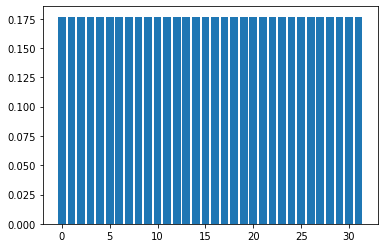

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [4]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [5]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

In [6]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


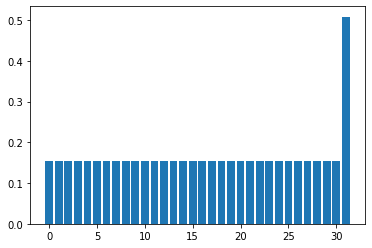

In [7]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

In [8]:
nqubits = 5

# グローバーのアルゴリズム
def grover(nqubits, operate_time):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


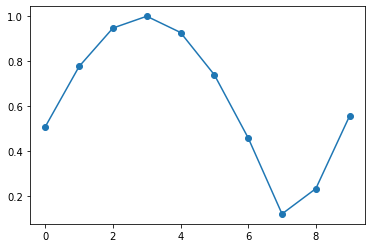

In [9]:
grover(5, 10)

## ランダムな初期状態の作成
次に、ランダムな初期状態を作成する。

In [10]:
from matplotlib.pyplot import tight_layout
fig = plt.figure(figsize=(8, 5))
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_time, seed):
    state = QuantumState(nqubits)
    state.set_zero_state()
    # 引数の値をシードとしてハール測度でランダムな純粋状態へ初期化
    # 指定値が無い場合はtime関数がシードとして使われる。疑似乱数はxorshiftを利用。
    state.set_Haar_random_state(0)
    print(f'state:{state}')

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()

    state.set_Haar_random_state(seed)
    print(f'state:{state}')

    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

<Figure size 576x360 with 0 Axes>

state: *** Quantum State ***
 * Qubit Count : 5
 * Dimension   : 32
 * State vector : 
   (0.0747502,0.217853)
   (0.153267,-0.169855)
  (0.0504751,-0.317087)
   (0.189953,0.0643675)
 (-0.0113997,0.0697621)
  (-0.188736,0.0737175)
  (-0.0211842,0.117014)
  (0.0898105,0.0127971)
  (0.0410571,0.0890812)
 (0.0399619,0.00664815)
 (-0.0738021,0.0260507)
 (-0.0860186,-0.261829)
    (0.17549,0.0182902)
   (0.054003,0.0573501)
  (0.159266,-0.0881395)
  (-0.201666,0.0705199)
 (-0.150994,-0.0174841)
   (-0.03556,0.0122293)
   (0.0476582,0.280667)
    (0.141343,0.269909)
   (0.0618683,0.134358)
 (-0.0018965,-0.060117)
 (-0.0444059,0.0290657)
 (-0.0644357,0.0329972)
   (-0.22016,0.0470145)
(-0.0509306,-0.0988854)
  (-0.198652,0.0238064)
 (0.283712,-0.00969501)
  (0.0765274,0.0541633)
  (0.00368996,0.107063)
(-0.0347809,-0.0410523)
    (-0.11087,0.149485)

state: *** Quantum State ***
 * Qubit Count : 5
 * Dimension   : 32
 * State vector : 
   (0.0747502,0.217853)
   (0.153267,-0.169855)
  (0.0504

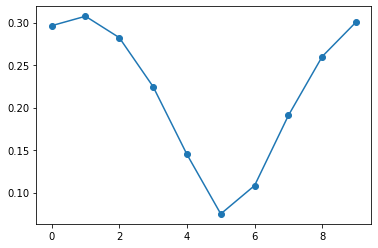

In [11]:
noisy_grover(5, 10, 0)

### シード値の変更
シード値が0〜10まででどうのような動きをするのか調べる

state: *** Quantum State ***
 * Qubit Count : 5
 * Dimension   : 32
 * State vector : 
   (0.0747502,0.217853)
   (0.153267,-0.169855)
  (0.0504751,-0.317087)
   (0.189953,0.0643675)
 (-0.0113997,0.0697621)
  (-0.188736,0.0737175)
  (-0.0211842,0.117014)
  (0.0898105,0.0127971)
  (0.0410571,0.0890812)
 (0.0399619,0.00664815)
 (-0.0738021,0.0260507)
 (-0.0860186,-0.261829)
    (0.17549,0.0182902)
   (0.054003,0.0573501)
  (0.159266,-0.0881395)
  (-0.201666,0.0705199)
 (-0.150994,-0.0174841)
   (-0.03556,0.0122293)
   (0.0476582,0.280667)
    (0.141343,0.269909)
   (0.0618683,0.134358)
 (-0.0018965,-0.060117)
 (-0.0444059,0.0290657)
 (-0.0644357,0.0329972)
   (-0.22016,0.0470145)
(-0.0509306,-0.0988854)
  (-0.198652,0.0238064)
 (0.283712,-0.00969501)
  (0.0765274,0.0541633)
  (0.00368996,0.107063)
(-0.0347809,-0.0410523)
    (-0.11087,0.149485)

state: *** Quantum State ***
 * Qubit Count : 5
 * Dimension   : 32
 * State vector : 
   (0.0747502,0.217853)
   (0.153267,-0.169855)
  (0.0504

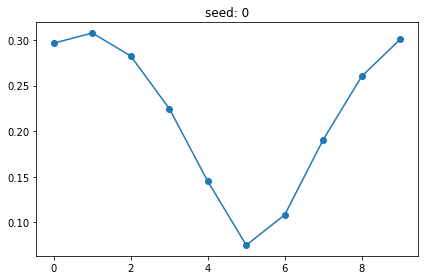

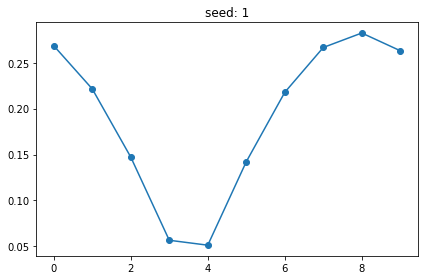

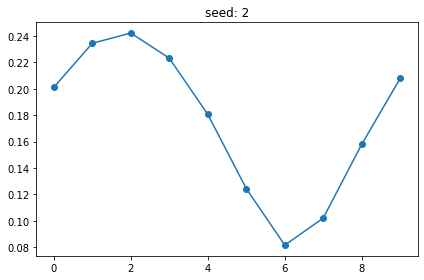

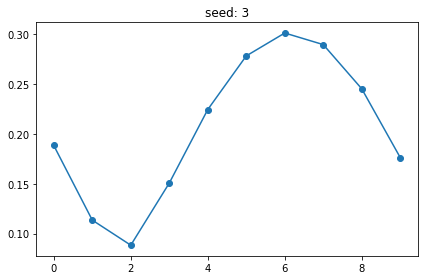

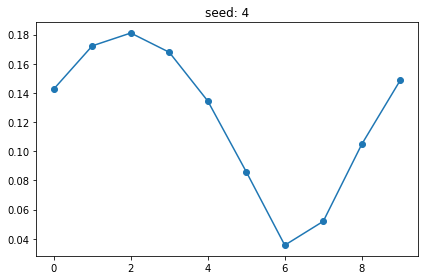

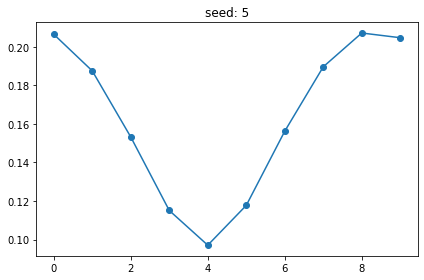

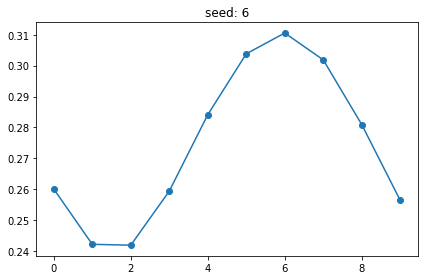

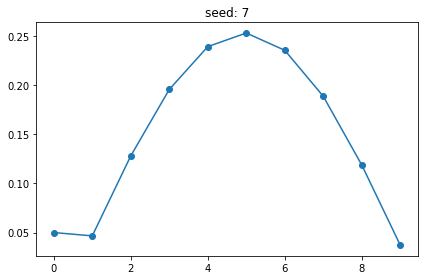

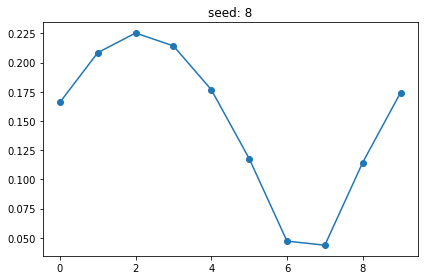

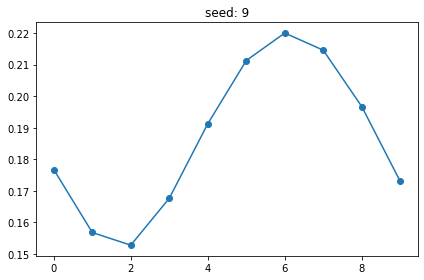

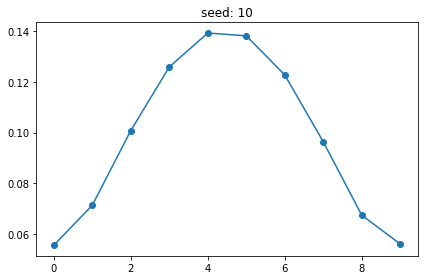

In [12]:
seed = 10
for i in range(seed + 1):
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'seed: {i}')

    noisy_grover(5, 10, i)